In [1]:
from datasets import load_dataset
import pandas as pd
from transformers import AutoTokenizer
import numpy as np
import tensorflow as tf
from transformers import TFBertForSequenceClassification, BertTokenizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


# Loading Data

In [18]:
dataset = load_dataset("trec")

- Verifying the GPU connection for TensorFlow.






In [19]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


# Training Data

In [5]:
train_dataset = dataset['train']

In [6]:
train_df = pd.DataFrame({'text' : train_dataset['text'], 'Fine_Label' : train_dataset['fine_label']})
train_df

,text,Fine_Label
0,How did serfdom develop in and then leave Russ...,26
1,What films featured the character Popeye Doyle ?,5
2,How can I find a list of celebrities ' real na...,26
3,What fowl grabs the spotlight after the Chines...,2
4,What is the full form of .com ?,1
...,...,...
5447,What 's the shape of a camel 's spine ?,13
5448,What type of currency is used in China ?,6
5449,What is the temperature today ?,47
5450,What is the temperature for cooking ?,47


# Testing Data

In [7]:
test_dataset = dataset['test']

In [8]:
test_df = pd.DataFrame({'text' : test_dataset['text'], 'Fine_Label' : test_dataset['fine_label']})
test_df

,text,Fine_Label
0,How far is it from Denver to Aspen ?,40
1,"What county is Modesto , California in ?",32
2,Who was Galileo ?,31
3,What is an atom ?,24
4,When did Hawaii become a state ?,39
...,...,...
495,Who was the 22nd President of the US ?,29
496,What is the money they use in Zambia ?,6
497,How many feet in a mile ?,38
498,What is the birthstone of October ?,18


#  Tokenization

In [15]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
tokenized_data = tokenizer(train_dataset["text"], return_tensors="np", padding=True)
tokenized_data = dict(tokenized_data) # Bert Model requires require in a dictionary format
labels = np.array(train_dataset["fine_label"]) 

- As you see How appear twice, What appear twice those are known as __stopwords__


In [9]:
# Load and compile our model
model = TFBertForSequenceClassification.from_pretrained("bert-base-cased",num_labels=50)
# Lower learning rates are often better for fine-tuning transformers

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#model.fit(tokenized_data, labels, epochs=10 ) # on next time

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Cross Validation

In [ ]:
train_df

,text,Fine_Label
0,How did serfdom develop in and then leave Russ...,26
1,What films featured the character Popeye Doyle ?,5
2,How can I find a list of celebrities ' real na...,26
3,What fowl grabs the spotlight after the Chines...,2
4,What is the full form of .com ?,1
...,...,...
5447,What 's the shape of a camel 's spine ?,13
5448,What type of currency is used in China ?,6
5449,What is the temperature today ?,47
5450,What is the temperature for cooking ?,47


In [ ]:
train_X = train_df[['text']]
train_y = train_df[['Fine_Label']]

In [12]:
from sklearn.model_selection import KFold

In [13]:
num_folds = 5
folds = KFold(n_splits=num_folds, shuffle=True)

In [10]:
def cross_validation(dataset):
    train_X = dataset[['text']]
    train_y = dataset[['Fine_Label']]
    for train_row_index, valid_row_index in folds.split(dataset):    
        '''  Splitting the training data into training and validation sets, then performing cross-validation  '''    
        train_x_new = train_X.iloc[train_row_index]
        print(train_x_new)
        valid_x = train_X.iloc[valid_row_index]

        train_y_new = train_y.iloc[train_row_index]
        valid_y = train_y.iloc[valid_row_index]   

        #Training
        tokenized_train_x_data = tokenizer(train_x_new['text'].to_list(), return_tensors="np", padding=True)
        tokenized_train_x_data = dict(tokenized_train_x_data)
        train_y_labels = np.array(train_y_new["Fine_Label"])


        #Fitting The Model
        model.fit(tokenized_train_x_data, train_y_labels, epochs=1 )

        #Validation
        tokenized_valid_x = tokenizer(valid_x['text'].to_list(), return_tensors="np", padding=True)
        tokenized_valid_x = dict(tokenized_valid_x)
        valid_y_labels = np.array(valid_y["Fine_Label"])

        #Prediction
        predictions = model.predict(tokenized_valid_x)
        class_probabilities = tf.nn.softmax(predictions.logits, axis=-1)
        predicted_labels = np.argmax(class_probabilities, axis=-1)

        accuracy = accuracy_score(valid_y_labels,predicted_labels) 
        precision = precision_score(valid_y_labels,predicted_labels,average='weighted')
        recall = recall_score(valid_y_labels,predicted_labels,average='weighted')
        f1 = f1_score(valid_y_labels,predicted_labels, average='weighted')

        print(f'Validation Accuracy: {accuracy * 100:.2f}%')
        print(f'Precision Accuracy: {precision * 100:.2f}%')
        print(f'recall Accuracy: {recall * 100:.2f}%')
        print(f'f1 Accuracy: {f1 * 100:.2f}%')

In [16]:
cross_validation(train_df)

                                                   text
1      What films featured the character Popeye Doyle ?
2     How can I find a list of celebrities ' real na...
3     What fowl grabs the spotlight after the Chines...
4                       What is the full form of .com ?
5     What contemptible scoundrel stole the cork fro...
...                                                 ...
5446                             Who was Buffalo Bill ?
5448           What type of currency is used in China ?
5449                    What is the temperature today ?
5450              What is the temperature for cooking ?
5451               What currency is used in Australia ?

[4361 rows x 1 columns]
35/35 [==============================] - 4s 59ms/step
Validation Accuracy: 74.15%
Precision Accuracy: 67.87%
recall Accuracy: 74.15%
f1 Accuracy: 68.05%
                                                   text
0     How did serfdom develop in and then leave Russ...
1      What films featured the charact

c:\Users\liang\anaconda3\envs\Anote_AI\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 [==============================] - 4s 62ms/step
Validation Accuracy: 83.41%
Precision Accuracy: 77.72%
recall Accuracy: 83.41%
f1 Accuracy: 79.92%
                                                   text
0     How did serfdom develop in and then leave Russ...
2     How can I find a list of celebrities ' real na...
3     What fowl grabs the spotlight after the Chines...
4                       What is the full form of .com ?
5     What contemptible scoundrel stole the cork fro...
...                                                 ...
5445    In what city does Maurizio Pellegrin now live ?
5446                             Who was Buffalo Bill ?
5447            What 's the shape of a camel 's spine ?
5449                    What is the temperature today ?
5450              What is the temperature for cooking ?

[4362 rows x 1 columns]


c:\Users\liang\anaconda3\envs\Anote_AI\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 [==============================] - 2s 58ms/step
Validation Accuracy: 91.38%
Precision Accuracy: 89.80%
recall Accuracy: 91.38%
f1 Accuracy: 89.95%
                                                   text
0     How did serfdom develop in and then leave Russ...
1      What films featured the character Popeye Doyle ?
2     How can I find a list of celebrities ' real na...
4                       What is the full form of .com ?
5     What contemptible scoundrel stole the cork fro...
...                                                 ...
5447            What 's the shape of a camel 's spine ?
5448           What type of currency is used in China ?
5449                    What is the temperature today ?
5450              What is the temperature for cooking ?
5451               What currency is used in Australia ?

[4362 rows x 1 columns]


c:\Users\liang\anaconda3\envs\Anote_AI\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 [==============================] - 2s 59ms/step
Validation Accuracy: 94.59%
Precision Accuracy: 94.10%
recall Accuracy: 94.59%
f1 Accuracy: 93.89%
                                                   text
0     How did serfdom develop in and then leave Russ...
1      What films featured the character Popeye Doyle ?
2     How can I find a list of celebrities ' real na...
3     What fowl grabs the spotlight after the Chines...
5     What contemptible scoundrel stole the cork fro...
...                                                 ...
5443  Where can I find information on becoming a jou...
5445    In what city does Maurizio Pellegrin now live ?
5447            What 's the shape of a camel 's spine ?
5448           What type of currency is used in China ?
5451               What currency is used in Australia ?

[4362 rows x 1 columns]


c:\Users\liang\anaconda3\envs\Anote_AI\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


35/35 [==============================] - 2s 58ms/step
Validation Accuracy: 96.24%
Precision Accuracy: 96.14%
recall Accuracy: 96.24%
f1 Accuracy: 95.81%


c:\Users\liang\anaconda3\envs\Anote_AI\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Predicting test_dataset row #2

In [20]:
test_df.iloc[[2]]

,text,Fine_Label
2,Who was Galileo ?,31


In [21]:
tokenized_data = tokenizer(test_dataset["text"][2], return_tensors="np", padding=True)
tokenized_data = dict(tokenized_data)
predictions = model.predict(tokenized_data)
class_probabilities = tf.nn.softmax(predictions.logits, axis=-1)
predicted_labels = np.argmax(class_probabilities, axis=-1)


1/1 [==============================] - 0s 82ms/step


In [22]:
predicted_labels # It's correct

array([31], dtype=int64)

In [ ]:
import tensorflow as tf

def prediction(text):
    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="tf", padding=True, truncation=True)
    inputs = dict(inputs)
    # Make predictions using the model
    logits = model(inputs)["logits"]

    # Calculate class probabilities and predicted labels
    class_probabilities = tf.nn.softmax(logits, axis=-1)
    predicted_labels = tf.argmax(class_probabilities, axis=-1).numpy()[0]

    return predicted_labels



In [3]:
label_to_id = {
    'ENTITY:Animal': 2,
    'ENTITY:body': 3,
    'ENTITY:color': 4,
    'ENTITY:cremat': 5,
    'ENTITY:currency': 6,
    'ENTITY:dismed': 7,
    'ENTITY:event': 8,
    'ENTITY:food': 9,
    'ENTITY:instru': 10,
    'ENTITY:lang': 11,
    'ENTITY:letter': 12,
    'ENTITY:other': 13,
    'ENTITY:plant': 14,
    'ENTITY:product': 15,
    'ENTITY:religion': 16,
    'ENTITY:sport': 17,
    'ENTITY:substance': 18,
    'ENTITY:symbol': 19,
    'ENTITY:techmeth': 20,
    'ENTITY:termeq': 21,
    'ENTITY:veh': 22,
    'ENTITY:word': 23,
    'DESCRIPTION:def': 24,
    'DESCRIPTION:desc': 25,
    'DESCRIPTION:manner': 26,
    'DESCRIPTION:reason': 27,
    'HUMAN:gr': 28,
    'HUMAN:ind': 29,
    'HUMAN:title': 30,
    'HUMAN:desc': 31,
    'LOCATION:city': 32,
    'LOCATION:country': 33,
    'LOCATION:mount': 34,
    'LOCATION:other': 35,
    'LOCATION:state': 36,
    'NUMERIC:code': 37,
    'NUMERIC:count': 38,
    'NUMERIC:date': 39,
    'NUMERIC:dist': 40,
    'NUMERIC:money': 41,
    'NUMERIC:ord': 42,
    'NUMERIC:other': 43,
    'NUMERIC:period': 44,
    'NUMERIC:perc': 45,
    'NUMERIC:speed': 46,
    'NUMERIC:temp': 47,
    'NUMERIC:volsize': 48,
    'NUMERIC:weight': 49
} 

id_to_label = { id : label for label, id in label_to_id.items()}

In [4]:
items = []
for item in label_to_id:
    items.append(item)

In [5]:
items

['ENTITY:Animal',
 'ENTITY:body',
 'ENTITY:color',
 'ENTITY:cremat',
 'ENTITY:currency',
 'ENTITY:dismed',
 'ENTITY:event',
 'ENTITY:food',
 'ENTITY:instru',
 'ENTITY:lang',
 'ENTITY:letter',
 'ENTITY:other',
 'ENTITY:plant',
 'ENTITY:product',
 'ENTITY:religion',
 'ENTITY:sport',
 'ENTITY:substance',
 'ENTITY:symbol',
 'ENTITY:techmeth',
 'ENTITY:termeq',
 'ENTITY:veh',
 'ENTITY:word',
 'DESCRIPTION:def',
 'DESCRIPTION:desc',
 'DESCRIPTION:manner',
 'DESCRIPTION:reason',
 'HUMAN:gr',
 'HUMAN:ind',
 'HUMAN:title',
 'HUMAN:desc',
 'LOCATION:city',
 'LOCATION:country',
 'LOCATION:mount',
 'LOCATION:other',
 'LOCATION:state',
 'NUMERIC:code',
 'NUMERIC:count',
 'NUMERIC:date',
 'NUMERIC:dist',
 'NUMERIC:money',
 'NUMERIC:ord',
 'NUMERIC:other',
 'NUMERIC:period',
 'NUMERIC:perc',
 'NUMERIC:speed',
 'NUMERIC:temp',
 'NUMERIC:volsize',
 'NUMERIC:weight']

In [ ]:
predictions = []
for text in test_dataset["text"]:
    predictions.append(prediction(text))

In [ ]:
test_df['Prediction'] = predictions

In [ ]:
test_df

,text,Fine_Label,Prediction
0,How far is it from Denver to Aspen ?,40,40
1,"What county is Modesto , California in ?",32,35
2,Who was Galileo ?,31,31
3,What is an atom ?,24,24
4,When did Hawaii become a state ?,39,39
...,...,...,...
495,Who was the 22nd President of the US ?,29,29
496,What is the money they use in Zambia ?,6,41
497,How many feet in a mile ?,38,38
498,What is the birthstone of October ?,18,24


In [ ]:
test_df.to_csv('Fine_Label_Prediction.csv', index=False)


In [ ]:
accuracy = accuracy_score(test_dataset['fine_label'],predictions) 
precision = precision_score(test_dataset['fine_label'],predictions,average='weighted')
recall = recall_score(test_dataset['fine_label'],predictions,average='weighted')
f1 = f1_score(test_dataset['fine_label'],predictions, average='weighted')

print(f' Accuracy: {accuracy * 100:.2f}%')
print(f'Precision Accuracy: {precision * 100:.2f}%')
print(f'recall Accuracy: {recall * 100:.2f}%')
print(f'f1 Accuracy: {f1 * 100:.2f}%')




Validation Accuracy: 93.20%
Precision Accuracy: 93.64%
recall Accuracy: 93.20%
f1 Accuracy: 92.86%


### Confusion Matrix

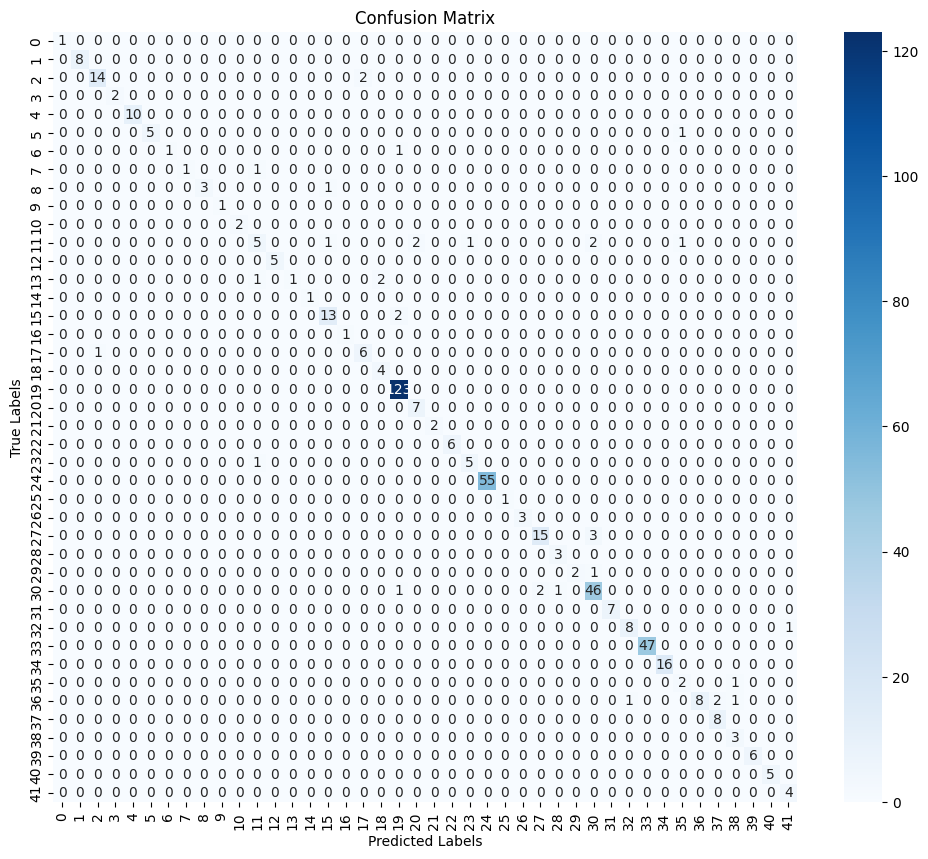

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(test_dataset['fine_label'], predictions)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Save the confusion matrix as an image
plt.savefig('confusion_matrix.png')
plt.show()
